# PRESELECCIÓN DE VARIABLES

## IMPORTAR PAQUETES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance


#Automcompletar rápido
%config IPCompleter.greedy=True

C:\Users\eloic\miniconda3\envs\mant_predictivo\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## IMPORTAR LOS DATOS

Sustituir la ruta del proyecto.

In [2]:
ruta_proyecto = 'C:/Users/eloic/Google Drive/EOI/TFM//01_MANT_PREDICTIVO'

Nombres de los ficheros de datos.

In [3]:
nombre_df = 'df_tablon.pickle'

Cargar los datos.

In [4]:
df = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_df)

## MÉTODOS SUPERVISADOS

### Preparar x e y

In [5]:
target = 'fallo'
x = df.drop(columns = ['fallo','fallo_Yes','fallo_No']).copy()
y = df['fallo_Yes']

### Mutual Information

#### Crear una función para mostrar el resultado

In [6]:
def ranking_mi(mutual_selector, modo = 'tabla'):
    #Maqueta el ranking
    ranking_mi = pd.DataFrame(mutual_selector, index = x.columns).reset_index()
    ranking_mi.columns = ['variable','importancia_mi']
    ranking_mi = ranking_mi.sort_values(by = 'importancia_mi', ascending = False)
    ranking_mi['ranking_mi'] = np.arange(0,ranking_mi.shape[0])
    #Muestra la salida
    if modo == 'tabla':
        return(ranking_mi)
    else:
        g = ranking_mi.importancia_mi.sort_values().plot.barh(figsize = (12,20))
        g.set_yticklabels(ranking_mi.sort_values(by = 'importancia_mi').variable)
        return(g)

#### Calcular y revisar

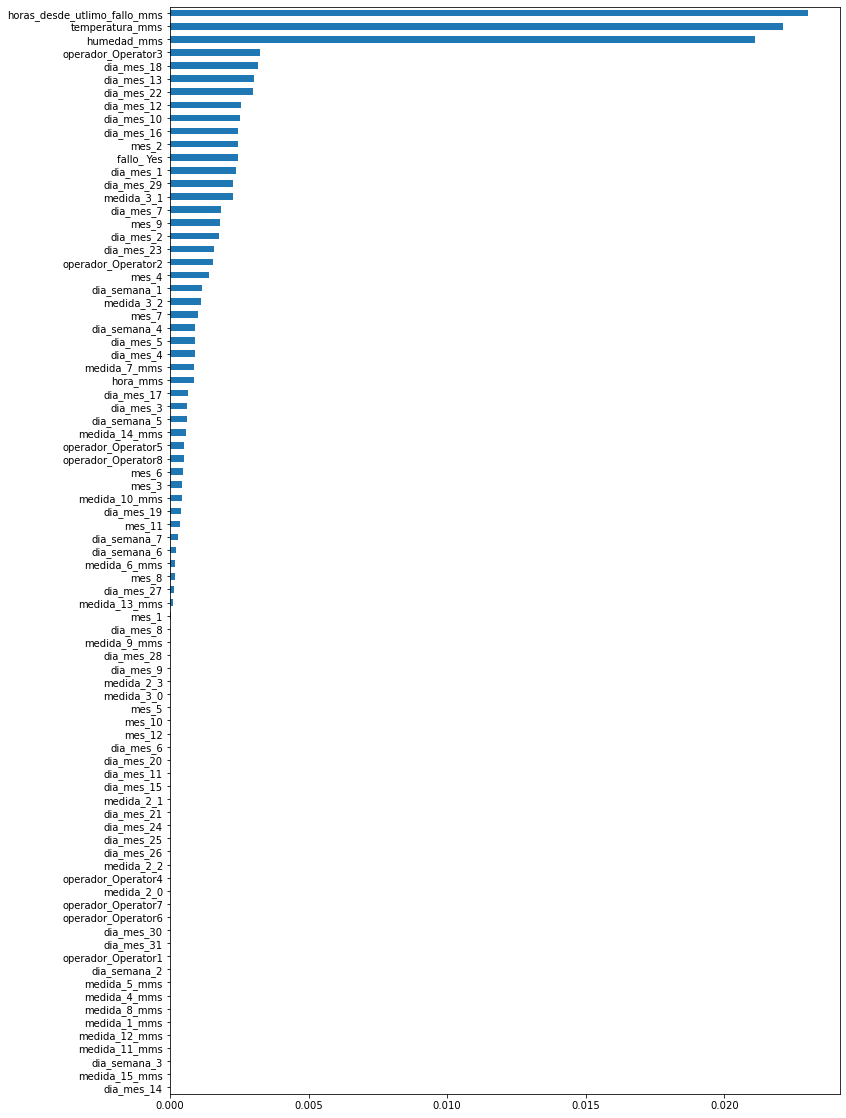

In [7]:
mutual_selector = mutual_info_classif(x,y)

rank_mi = ranking_mi(mutual_selector, modo = 'grafico')

#### Seleccionar las variables que pasan

##### Definir la posición de la última variable que va a entrar

In [8]:
posicion_variable_limite = 39

##### Extraer los nombres de las que entran

In [9]:
entran_mi = ranking_mi(mutual_selector).iloc[0:posicion_variable_limite].variable

##### Crear el dataframe con la selección

In [10]:
x_mi = x[entran_mi].copy()

### Recursive Feature Elimination

#### Instanciar

In [11]:
rfe = RFE(estimator = XGBClassifier(use_label_encoder=False, n_jobs = -1, eval_metric='auc'))

#### Entrenar

In [12]:
rfe.fit(x,y)

RFE(estimator=XGBClassifier(base_score=None, booster=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, enable_categorical=False,
                            eval_metric='auc', gamma=None, gpu_id=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=None, max_delta_step=None,
                            max_depth=None, min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=-1, num_parallel_tree=None, predictor=None,
                            random_state=None, reg_alpha=None, reg_lambda=None,
                            scale_pos_weight=None, subsample=None,
                            tree_method=None, use_label_encoder=False,
                            validate_parameters=None, verbosity=None))

##### Extraer los nombres de las que entran

In [13]:
entran_rfe = x.columns[rfe.support_]

In [14]:
entran_rfe

Index(['operador_Operator1', 'operador_Operator4', 'operador_Operator5',
       'operador_Operator7', 'operador_Operator8', 'medida_2_1', 'medida_2_2',
       'medida_3_0', 'medida_3_1', 'mes_3', 'mes_4', 'mes_9', 'mes_11',
       'mes_12', 'dia_mes_2', 'dia_mes_5', 'dia_mes_7', 'dia_mes_10',
       'dia_mes_19', 'dia_mes_25', 'dia_semana_1', 'dia_semana_2',
       'dia_semana_4', 'dia_semana_5', 'temperatura_mms', 'humedad_mms',
       'medida_1_mms', 'medida_4_mms', 'medida_5_mms', 'medida_6_mms',
       'medida_7_mms', 'medida_8_mms', 'medida_9_mms', 'medida_10_mms',
       'medida_11_mms', 'medida_12_mms', 'medida_13_mms', 'medida_14_mms',
       'medida_15_mms', 'horas_desde_utlimo_fallo_mms', 'hora_mms'],
      dtype='object')

#### Crear el dataframe con la selección

In [15]:
x_rfe = x[entran_rfe].copy()

### Permutation Importance

#### Crear una función para mostrar el resultado

In [16]:
def ranking_per(predictoras,permutacion):
    ranking_per = pd.DataFrame({'variable': predictoras.columns, 'importancia_per': permutacion.importances_mean}).sort_values(by = 'importancia_per', ascending = False)
    ranking_per['ranking_per'] = np.arange(0,ranking_per.shape[0])
    return(ranking_per)

#### Instanciar y entrenar

In [17]:
import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')

xgb = XGBClassifier(use_label_encoder=False, n_jobs = -1, eval_metric='auc')

xgb.fit(x,y)

permutacion = permutation_importance(xgb, 
                                     x, y, 
                                     scoring = 'roc_auc',
                                     n_repeats=5, n_jobs = -1)

C:\Users\eloic\miniconda3\envs\mant_predictivo\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


#### Revisar la salida

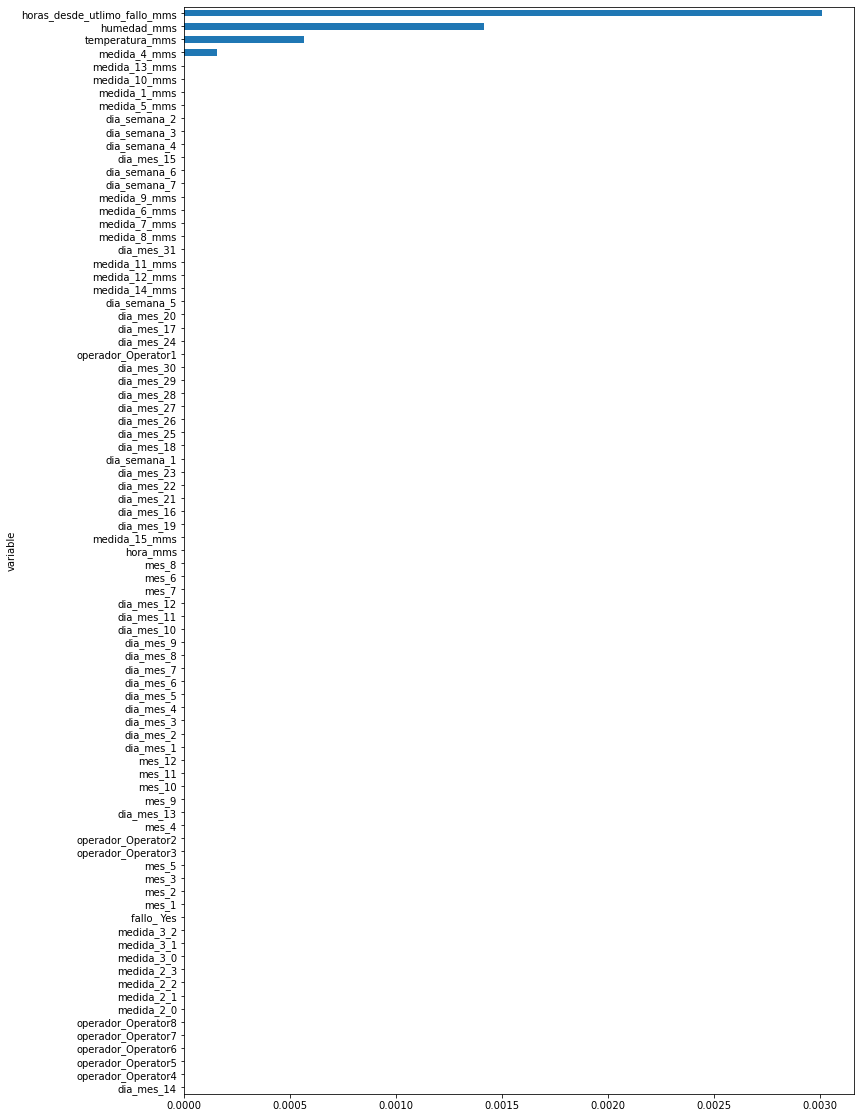

In [18]:
rank_per = ranking_per(x,permutacion)

rank_per.set_index('variable').importancia_per.sort_values().plot.barh(figsize = (12,20));

#### Seleccionar las variables que pasan

##### Definir la posición de la última variable que va a entrar

In [19]:
posicion_variable_limite = 3

##### Extraer los nombres de las que entran

In [20]:
entran_per = rank_per.iloc[0:posicion_variable_limite].variable

In [21]:
entran_per

81    horas_desde_utlimo_fallo_mms
67                     humedad_mms
66                 temperatura_mms
Name: variable, dtype: object

##### Crear el dataframe con la selección

In [22]:
x_per = x[entran_per].copy()

## SELECCIONAR EL MÉTODO FINAL

Descomentar el método de preselección elegido y dejar comentados el resto.

In [23]:
#x_preseleccionado = x_mi
# x_preseleccionado = x_rfe
x_preseleccionado = x_per

## MÉTODOS NO SUPERVISADOS

### Correlación

#### Crear una función para mostrar el resultado

In [24]:
def correlaciones_fuertes(df, lim_inf = 0.3, lim_sup = 1,drop_dupli=True):
    #Calcula la matriz de correlación
    c = df.corr().abs()
    #Lo pasa todo a filas
    c= c.unstack()
    #Pasa el índice a columnas y le pone nombres
    c = pd.DataFrame(c).reset_index()
    c.columns = ['var1','var2','corr']
    #A dataframe, filtra limites y ordena en descendiente
    c = c.loc[(c['corr'] > lim_inf) &  (c['corr'] < lim_sup),:].sort_values(by = 'corr', ascending=False)
    #Desduplica las correlaciones (o no si drop_dupli es False)
    c = c if drop_dupli == False else c.drop_duplicates(subset = ['corr'])
    #Devuelve la salida
    return(c)

#### Calcular y revisar

##### Calcular

In [25]:
cor_finales = correlaciones_fuertes(x_preseleccionado)

##### Revisar agregado

In [26]:
cor_finales.var1.value_counts()

Series([], Name: var1, dtype: int64)

##### Revisar detalle

In [27]:
cor_finales.head(50)

,var1,var2,corr


#### Filtrar variables

Meter en una lista las que queramos descartar por alta correlacion y eliminarlas.

In [28]:
a_eliminar_corr = []

In [29]:
x_preseleccionado.drop(columns = a_eliminar_corr, inplace = True)

In [30]:
x_preseleccionado.columns.to_list()

['horas_desde_utlimo_fallo_mms', 'humedad_mms', 'temperatura_mms']

## GUARDAR DATASETS TRAS PRESELECCION DE VARIABLES

In [31]:
#Definir los nombres de los archivos
nombre_x_preseleccionado = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'x_preseleccionado.pickle'
nombre_y_preseleccionado = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'y_preseleccionado.pickle'

In [32]:
#Guardar los archivos
x_preseleccionado.to_pickle(nombre_x_preseleccionado)

y_preseleccionado = y.copy()
y_preseleccionado.to_pickle(nombre_y_preseleccionado)

In [33]:
#Guardar los nombres de las variables finales
nombre_variables_finales = ruta_proyecto + '/05_Resultados/' + 'variables_finales.pickle'

x_preseleccionado.iloc[0].to_pickle(nombre_variables_finales)